In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import seaborn as sn
import pickle
from scipy import io
import networkx as nx

In [9]:
# A_T= np.zeros((50, 50), dtype=float)
# A_T[1::2, ::2] = 1
# A_T[::2, 1::2] = 1
A_T=np.array(np.random.randint(2,size=(50,50)),dtype=float)
print(A_T)
A_T_ORG=A_T
np.save('AT',A_T)

[[0. 0. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 1.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 1. 0.]]


In [10]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [11]:
# def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
#     big_sum= 0
#     Z=0
#     first_loop_cond = True
#     for part in all_part:
#
#         if first_loop_cond:
#             gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
#             pair_list=[]
#             for x in gooz_list:
#                 if x not in pair_list: pair_list.append(x)
#
#             # H(p) formula
#             H_P = 0
#             for pair in pair_list:
#                 alpha, beta = pair
#                 l = l_ij(alpha, beta, A_T, part)
#                 r = r_ij(alpha, beta, part)
#                 h_p = math.log(r+1) + math.log(ncr(r, l))
#                 H_P += h_p
#
#             Z += np.exp(-H_P)
#             first_loop_cond = False
#         # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)
#
#
#         # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
#         sigma_i = index_2d(part, i)[0]
#         sigma_j = index_2d(part, j)[0]
#         l = l_ij(sigma_i , sigma_j , A_T, part)
#         r = r_ij(sigma_i , sigma_j , part)
#         parantez = ((l + 1)/(r+2))
#
#         # print(Z)
#         big_sum += parantez* np.exp(-H_P)
#         R_ij = big_sum/Z
#         # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
#     return(round(R_ij,5))
#

def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    for part in all_part:

        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        paran = ((l + 1)/(r+2))

        gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
        pair_list=[]
        for x in gooz_list:
            if x not in pair_list: pair_list.append(x)
        H_P = 0
        for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, part)
            r = r_ij(alpha, beta, part)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
        Z += np.exp(-H_P)
        big_sum += paran* np.exp(-H_P)
        R_ij = big_sum/Z
    # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))



In [12]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P,AT_tmp):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<=j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, AT_tmp, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

In [13]:
def Metropolis(T,ens,AT_tmp):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(AT_tmp.shape[0])].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions,AT_tmp) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions,AT_tmp)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
        ppp = [ele for ele in partitions if ele != []]
        e.append(ppp)
        #     partitions = [ele for ele in partitions if ele != []]
        #
        # ppp=copy.deepcopy(partitions)
        # e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions,AT_tmp))
        print(kk)
    return(e)

In [14]:
es = Metropolis(100, 20,A_T)

  5%|▌         | 1/20 [00:00<00:05,  3.65it/s]

881.1875299142905
99


 10%|█         | 2/20 [00:00<00:05,  3.55it/s]

880.0871107410901
99


 15%|█▌        | 3/20 [00:00<00:04,  3.65it/s]

888.1711177210285
99


 20%|██        | 4/20 [00:01<00:04,  3.76it/s]

890.9567685391332
99


 25%|██▌       | 5/20 [00:01<00:03,  3.78it/s]

876.2177166147161
99


 30%|███       | 6/20 [00:01<00:03,  3.61it/s]

880.3239947594142
99


 35%|███▌      | 7/20 [00:01<00:03,  3.68it/s]

887.0129605190349
99


 40%|████      | 8/20 [00:02<00:03,  3.87it/s]

880.3578950353127
99


 45%|████▌     | 9/20 [00:02<00:02,  3.91it/s]

880.5212580228646
99


 50%|█████     | 10/20 [00:02<00:02,  3.66it/s]

883.1939687747853
99


 55%|█████▌    | 11/20 [00:02<00:02,  3.84it/s]

886.2001216485862
99


 60%|██████    | 12/20 [00:03<00:02,  3.85it/s]

886.0321312660266
99


 65%|██████▌   | 13/20 [00:03<00:01,  3.83it/s]

878.0541631728983
99


 70%|███████   | 14/20 [00:03<00:01,  3.74it/s]

887.1171792280484
99


 75%|███████▌  | 15/20 [00:03<00:01,  3.83it/s]

882.6470708604542
99


 80%|████████  | 16/20 [00:04<00:01,  3.92it/s]

888.3410167578239
99


 85%|████████▌ | 17/20 [00:04<00:00,  3.91it/s]

893.5996965647531
99


 90%|█████████ | 18/20 [00:04<00:00,  3.87it/s]

879.8354342031431
99


 95%|█████████▌| 19/20 [00:05<00:00,  3.82it/s]

889.752635713237
99


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]

893.5317581241671
99


In [15]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

We are computing the reliability of links that were originally set to zero in the adjacency matrix A_T. The code we've provided iterates through the zero entries in the adjacency matrix and calculates the reliability using the R function.

In [16]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    #computed reliability for each link is appended to the zero_real list
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

100%|██████████| 1260/1260 [00:26<00:00, 47.00it/s]


In [17]:
rat=np.linspace(0.1,1,10) #removal ratio
accs=[]
for r in rat:
    A_T_ORG=A_T
    selected_links = link_remover(A_T, r) #select links to remove from the adjacency matrix (based on ratio)
    #Set the selected links to 0 in the adjacency matrix to simulate link removal.
    #print(selected_links)
    for link in selected_links: A_T[link[0], link[1]] = 0 #index 0 and index 1
    #Calculate the reliability of the removed links using the R function and store these values in the zero_fake list.
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    #Print the mean value of the reliabilities of the removed links
    print('the mean value', round(np.mean(zero_fake),2))
    #aggregate all the reliabilities (both real and removed)
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    #print(all_real)
    Sort(all_real)
    #print(all_real)
    #print('..............................')
    ext=Extract(all_real)
    #print(ext)
    #calculate the accuracy of the network based on the sorted reliabilities
    accs.append(acc(ext))

the mean value 0.35
the mean value 0.34
the mean value 0.35
the mean value 0.34
the mean value 0.31
the mean value 0.32
the mean value 0.3
the mean value 0.3
the mean value 0.3
the mean value 0.3


#### CONCLUSION:
This information helps us to understand how network reliability changes as we remove links.
Based on these results, it appears that as we remove more links, the mean reliability of the removed links decreases. This is an expected outcome, as removing links reduces the network's overall connectivity and makes it less reliable in terms of link connectivity. The decreasing trend in mean reliability suggests that removing more links has a more significant impact on network reliability.

Text(0.5, 1.0, 'Missing intractions')

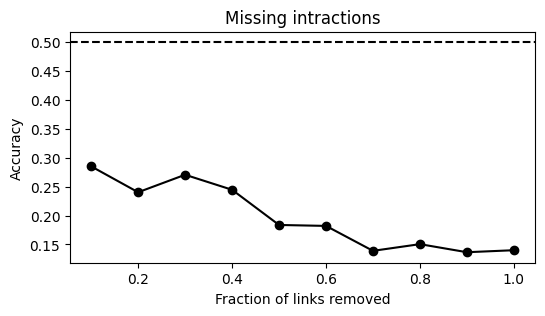

In [18]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')


### Spurious Intercations (Adding Links)

In [19]:
#add links to the adjacency matrix A_T based on a specified ratio
def link_adder(A_T, ratio):
    zero_index = np.where(A_T==0)
    zero_list = [[zero_index[0][i], zero_index[1][i]] for i in range(len(zero_index[0]))]
    r = random.sample(zero_list, int(ratio * np.sum(A_T)/2))
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
#This function is intended to extract the first elements from a list of pairs
def Extract(lst):
    return list(list(zip(*lst))[0])


In [20]:
def acc(k):
    zeros = k.count(0)
    ones = k.count(1)

    if zeros == 0:
        return 0  # Handle the case when there are no zeros (or return another appropriate value)

    ef = 0
    for i in range(len(k)):
        if k[i] == 1:
            ef += k[i:].count(0) / zeros

    return ef / ones

In [21]:
one_real = []
one_index = np.where(A_T==1)#find the indices of one entries in the adjacency matrix

for i in tqdm(range(len(one_index[0]))):
    #computed reliability for each link is appended to the one_real list
    one_real.append(R(one_index[0][i], one_index[1][i], A_T, es))

100%|██████████| 41/41 [00:00<00:00, 47.72it/s]


In [22]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    A_T = np.load('AT.npy')
    selected_links = link_adder(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 1
    np.save('A0',A_T)
    one_fake=[]
    for i in selected_links:
        one_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(one_fake),2))
    all_real = []
    for i in one_fake: all_real.append([0, i])
    for i in one_real: all_real.append([1, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

the mean value 0.62
the mean value 0.66
the mean value 0.64
the mean value 0.66
the mean value 0.65
the mean value 0.66
the mean value 0.67
the mean value 0.67
the mean value 0.67
the mean value 0.67


##### conclusion:
the mean values of the reliabilities for added links as we systematically increased the link addition ratio. This information helps us to understand how network reliability changes as we add more links.it appears that as we add more links to the network, the mean reliability of the added links increases. This suggests that adding more links enhances network reliability. The increasing trend in mean reliability indicates that adding more links has a positive impact on the network's reliability.

Text(0.5, 1.0, 'ُSpurious intractions')

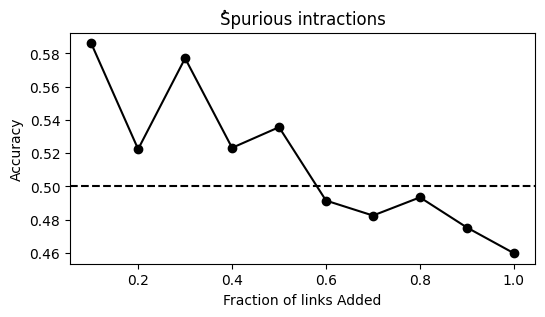

In [23]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links Added')
plt.title('ُSpurious intractions')

### Load True Network and observed Network

In [24]:
A_O = np.load('A0.npy')
A_T = np.load('AT.npy')

In [25]:
num_zeros_A_T = (A_T == 0).sum()
print('number of zero in true network',num_zeros_A_T)
num_one_A_T = (A_T == 1).sum()
print('number of one in true network',num_one_A_T)

number of zero in true network 1260
number of one in true network 1240


In [26]:
num_zeros_A_O = (A_O == 0).sum()
print('number of zero in A_O network',num_zeros_A_O)
num_one_A_O = (A_O == 1).sum()
print('number of one in A_O network',num_one_A_O)

number of zero in A_O network 640
number of one in A_O network 1860


In [27]:
# create empty matrix of shape A_O
shape_o=np.shape(A_O)
R_matix=np.zeros(shape_o)
es = Metropolis(100, 20,A_O)

  0%|          | 0/20 [00:00<?, ?it/s]

809.4744567862025

  5%|▌         | 1/20 [00:00<00:03,  5.27it/s]


99


 10%|█         | 2/20 [00:00<00:03,  5.67it/s]

826.4479723483007
99


 15%|█▌        | 3/20 [00:00<00:02,  5.91it/s]

820.3132755319499
99


 20%|██        | 4/20 [00:00<00:02,  5.77it/s]

827.7868437915029
99


 25%|██▌       | 5/20 [00:00<00:02,  6.04it/s]

804.3795258358506
99


 30%|███       | 6/20 [00:01<00:02,  6.16it/s]

825.087259279064
99


 35%|███▌      | 7/20 [00:01<00:02,  6.00it/s]

822.8858090300491
99


 40%|████      | 8/20 [00:01<00:02,  5.95it/s]

799.2225663010369
99


 45%|████▌     | 9/20 [00:01<00:01,  6.03it/s]

802.151873336158
99


 50%|█████     | 10/20 [00:01<00:01,  6.09it/s]

815.7090578494161
99


 55%|█████▌    | 11/20 [00:01<00:01,  5.92it/s]

844.0705878357427
99


 60%|██████    | 12/20 [00:02<00:01,  5.98it/s]

815.3564381644339
99


 65%|██████▌   | 13/20 [00:02<00:01,  5.85it/s]

830.0693704618525
99


 70%|███████   | 14/20 [00:02<00:01,  5.87it/s]

810.9465954109415
99
822.6982427718975

 80%|████████  | 16/20 [00:02<00:00,  5.71it/s]


99
828.6706203870192
99


 90%|█████████ | 18/20 [00:03<00:00,  6.03it/s]

799.2743995800024
99
823.2888064573698
99


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]

823.0918740192662
99
821.750262033782
99


### Calculating the reliability matrix for Observed network & true network

In [28]:
for i in range(shape_o[0]):
    for j in range(shape_o[1]):
        R_matix[i][j]= R(i,j, A_O, es)

In [29]:
print(np.max(R_matix))
print(np.min(R_matix))
R_matix

0.90035
0.16983


array([[0.66207, 0.89431, 0.66897, ..., 0.625  , 0.75604, 0.6556 ],
       [0.5    , 0.77356, 0.89905, ..., 0.71248, 0.66983, 0.60886],
       [0.83276, 0.70664, 0.49828, ..., 0.63449, 0.75259, 0.5    ],
       ...,
       [0.74526, 0.84359, 0.625  , ..., 0.81876, 0.5962 , 0.50633],
       [0.50518, 0.5    , 0.74914, ..., 0.21613, 0.67242, 0.50949],
       [0.5    , 0.79494, 0.66983, ..., 0.87342, 0.50949, 0.82701]])

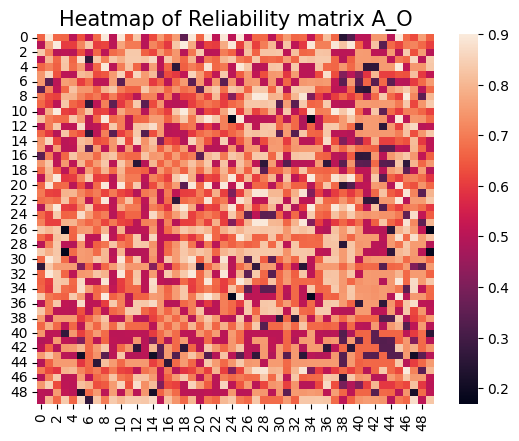

In [47]:
hm = sn.heatmap(data = R_matix)
#the plotted heatmap
plt.title('Heatmap of Reliability matrix A_O', fontsize = 15)
plt.show()

In [55]:
A_O[np.where(R_matix > 0.5)] = 1
A_O[np.where(R_matix < 0.5)] = 0

Text(0.5, 1.0, 'Reliability matrix for A_O')

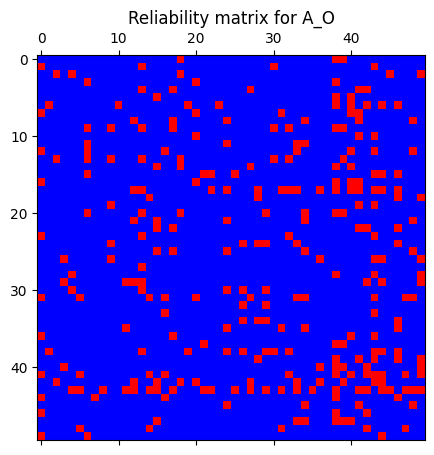

In [56]:
from matplotlib.colors import ListedColormap
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
cmap = ListedColormap(['r', 'b'])
ax1.matshow(A_O, interpolation=None, aspect='auto',cmap=cmap)
ax1.set_title('Reliability matrix for A_O')

In [32]:
shape_T=np.shape(A_T)
R_mat_A_T=np.zeros(shape_T)
es = Metropolis(100, 20,A_O)

 10%|█         | 2/20 [00:00<00:02,  6.25it/s]

600.4407049889431
99
622.9030183062016
99


 20%|██        | 4/20 [00:00<00:02,  6.80it/s]

593.7844700456765
99
623.9930733066218
99


 30%|███       | 6/20 [00:00<00:02,  6.88it/s]

606.0776151875245
99
624.5092832206382
99


 40%|████      | 8/20 [00:01<00:01,  6.80it/s]

603.4583816604977
99
629.2533277536301
99


 50%|█████     | 10/20 [00:01<00:01,  6.98it/s]

630.7653549975447
99
585.3358720185722
99


 60%|██████    | 12/20 [00:01<00:01,  6.95it/s]

609.4361804836035
99
603.5451963975647
99


 70%|███████   | 14/20 [00:02<00:00,  6.88it/s]

603.8529062492703
99
607.2664830897818
99


 80%|████████  | 16/20 [00:02<00:00,  6.25it/s]

608.2592419951745
99
628.162508182538
99


 90%|█████████ | 18/20 [00:02<00:00,  6.48it/s]

632.861312917124
99
592.9103079392152
99


100%|██████████| 20/20 [00:02<00:00,  6.70it/s]

628.4745586080022
99
598.1610277986804
99


In [33]:
for i in range(shape_T[0]):
    for j in range(shape_T[1]):
        R_mat_A_T[i][j]= R(i,j, A_T, es)

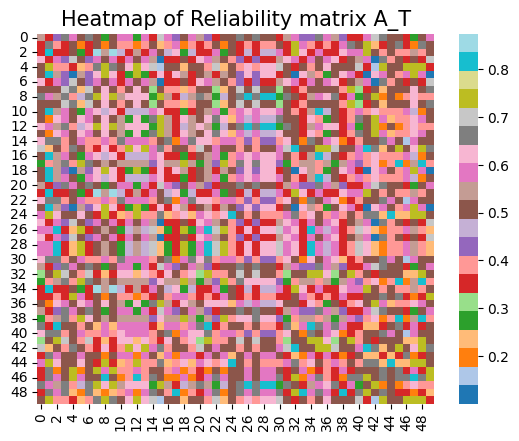

In [48]:
cmap = "tab20"
hm = sn.heatmap(data = R_mat_A_T,cmap=cmap)
plt.title('Heatmap of Reliability matrix A_T', fontsize = 15)
#the plotted heatmap
plt.show()

In [34]:
print(np.max(R_mat_A_T))
print(np.min(R_mat_A_T))
R_mat_A_T

0.87373
0.10052


array([[0.55521, 0.33388, 0.42889, ..., 0.2865 , 0.49966, 0.59918],
       [0.33355, 0.66754, 0.39987, ..., 0.20157, 0.66514, 0.50131],
       [0.35784, 0.7981 , 0.3643 , ..., 0.54487, 0.40018, 0.49971],
       ...,
       [0.64291, 0.59948, 0.54601, ..., 0.63541, 0.40219, 0.37408],
       [0.33341, 0.66579, 0.59868, ..., 0.20277, 0.33254, 0.25079],
       [0.50029, 0.74869, 0.37595, ..., 0.74921, 0.74921, 0.33333]])

In [35]:
A_T[np.where(R_mat_A_T > 0.5)] = 1
A_T[np.where(R_mat_A_T < 0.5)] = 0

Text(0.5, 1.0, 'Reliability matrix for A_T')

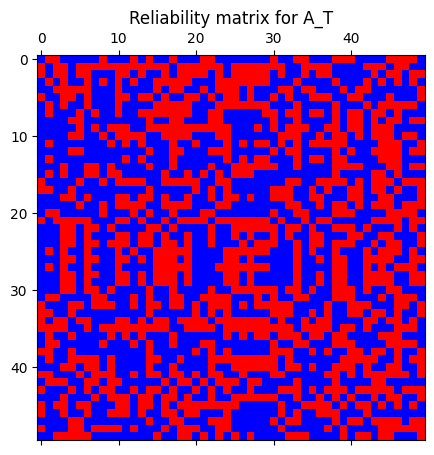

In [36]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
cmap = ListedColormap(['r', 'b'])
ax1.matshow(A_T, interpolation=None, aspect='auto',cmap=cmap)
ax1.set_title('Reliability matrix for A_T')


Text(0.5, 1.0, 'Difference of A_O and A_T')

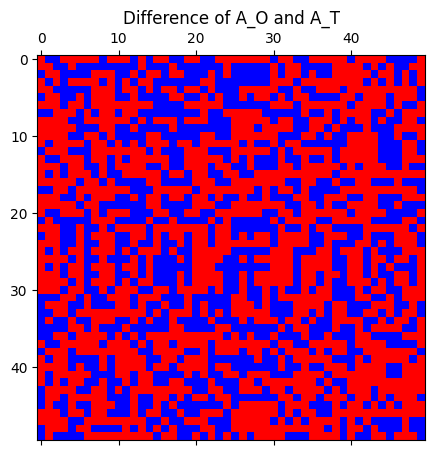

In [52]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
cmap = ListedColormap(['r', 'b'])
ax1.matshow(abs(A_O - A_T), interpolation=None, aspect='auto', cmap=cmap)
ax1.set_title('Difference of A_O and A_T')